In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

This data comes from "The County Health Rankings" created by the Robert Wood Johnson Foundation (RWJF). It contains statistics from each county and year on various happiness indicators:
FairPoor = % of people that say their helath is fair or poor.
Phys_U   = average # of physically unhealthy days per month
SmokeR   = % of adults that smoke
TBirthR  = # of teen births per thousand females age 15-19
UnempR   = % of population age 16+ that are unemployed
DAloneR  = % of workers that drive alone to work

We also have confidence intervals around each of the variables as well, because the estimates are often based on very small sample sizes.

We'll use this data to predict the amount of net migration per year into or out of the county.

In [2]:
train = pd.read_csv('ProjData.csv')

In [3]:
train.describe()

,net_mig,population,Deaths,YPLLR,YPLLR_LO,YPLLR_HI,FairPoor,FairPoor_LO,FairPoor_HI,PhysU,...,AssocR,AlcMVDR_LO,AlcMVDR_HI,DWViol,ChildPovBR,ChildPovHR,ChildPovWR,DAloneBR,DAloneHR,DAloneWR
count,25080.000000,2.508000e+04,23873.000000,23871.000000,23871.000000,23871.000000,22694.000000,22692.000000,22692.000000,23591.000000,...,9418.000000,6170.000000,6170.000000,6277.000000,1472.000000,2124.000000,3059.000000,1149.000000,1241.000000,3020.000000
mean,288.459968,1.012639e+05,1090.571818,8174.293913,6874.670395,9557.387877,16.971402,13.782963,21.063018,3.811398,...,13.867297,20.361750,42.414749,2.489246,42.447690,35.012712,17.512259,76.393386,70.068493,79.545364
std,2238.549380,3.242845e+05,2896.758404,2442.698133,2117.431512,3014.593367,5.649310,5.158345,7.298106,1.027520,...,7.056757,13.244845,13.641864,0.536513,17.364058,16.606196,8.446196,9.677743,10.185900,7.645698
min,-45360.000000,8.400000e+01,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,5.000000,0.600000,...,0.000000,0.000000,11.000000,1.000000,2.000000,1.000000,0.000000,4.000000,6.000000,10.000000
25%,-112.000000,1.105775e+04,180.000000,6447.000000,5369.000000,7420.000000,13.000000,10.000000,15.000000,3.100000,...,9.400000,10.000000,33.000000,2.000000,30.000000,23.000000,11.000000,73.000000,65.000000,77.000000
50%,-9.000000,2.582050e+04,382.000000,7856.000000,6635.000000,9151.000000,16.000000,13.000000,20.000000,3.700000,...,12.600000,20.000000,40.000000,3.000000,42.000000,33.000000,17.000000,78.000000,72.000000,81.000000
75%,108.000000,6.756400e+04,895.000000,9587.000000,8142.000000,11269.000000,20.000000,17.000000,25.000000,4.400000,...,16.700000,29.000000,50.000000,3.000000,54.000000,44.000000,23.000000,82.000000,77.000000,84.000000
max,55537.000000,1.016351e+07,80666.000000,28822.000000,22713.000000,44155.000000,51.000000,41.000000,70.000000,11.200000,...,82.500000,81.000000,91.000000,3.000000,98.000000,92.000000,64.000000,98.000000,93.000000,94.000000


In [4]:
train.isna().sum(axis = 0)

net_mig            43
population         43
Deaths           1250
YPLLR            1252
YPLLR_LO         1252
YPLLR_HI         1252
FairPoor         2429
FairPoor_LO      2431
FairPoor_HI      2431
PhysU            1532
PhysU_LO         1534
PhysU_HI         1534
MentU            2000
MentU_LO         2002
MentU_HI         2002
LBWR             1413
LBWR_LO          1770
LBWR_HI          1770
SmokeR           3445
SmokeR_LO        3450
SmokeR_HI        3450
ObeseR              0
ObeseR_LO          11
ObeseR_HI          11
AlcR             3979
AlcR_LO          3998
AlcR_HI          3998
MVDeathR        13239
MVDeathR_LO     13239
MVDeathR_HI     13239
                ...  
FoodEnvI        12564
ExerciseAR      12748
AlcMVDR         12655
MHPR            13892
GradClass       14705
IDeathR         13207
IDeathR_LO      13208
IDeathR_HI      13208
SHProbsR        12564
SHProbsR_LO     12568
SHProbsR_HI     12568
DAloneR         12565
DAloneR_LO      12683
DAloneR_HI      12683
LCDAloneR 

Most of the columns have thousands of missing values. This is because the RWJF changes the variables it uses to calculate the index year by year. We'll just fill those in with the median for each column. This will reduce the importance of those variables overall, but it may be helpful to include them.

In [ ]:
train.dtypes

net_mig         float64
population      float64
Deaths          float64
YPLLR           float64
YPLLR_LO        float64
YPLLR_HI        float64
FairPoor        float64
FairPoor_LO     float64
FairPoor_HI     float64
PhysU           float64
PhysU_LO        float64
PhysU_HI        float64
MentU           float64
MentU_LO        float64
MentU_HI        float64
LBWR            float64
LBWR_LO         float64
LBWR_HI         float64
SmokeR          float64
SmokeR_LO       float64
SmokeR_HI       float64
ObeseR            int64
ObeseR_LO       float64
ObeseR_HI       float64
AlcR            float64
AlcR_LO         float64
AlcR_HI         float64
MVDeathR        float64
MVDeathR_LO     float64
MVDeathR_HI     float64
                 ...   
FoodEnvI        float64
ExerciseAR      float64
AlcMVDR         float64
MHPR            float64
GradClass       float64
IDeathR         float64
IDeathR_LO      float64
IDeathR_HI      float64
SHProbsR        float64
SHProbsR_LO     float64
SHProbsR_HI     

In [ ]:
train = train.fillna(train.median())

We can now look at the correlation between all of our variables and our target variable: net migration.

In [ ]:
train.corr()['net_mig'].sort_values(ascending = False)

net_mig         1.000000
population      0.286629
LaborForce      0.269436
NumHH           0.266237
Deaths          0.248736
Mcare           0.204979
ViCrime         0.165575
GradClass       0.164018
MammR_LO        0.160616
PSED            0.149219
PSED_LO         0.146138
ExerciseAR      0.131244
Inc80           0.124804
HbA1cR_LO       0.123136
SHProbsR_LO     0.119141
Inc20           0.108254
LCDAloneR_LO    0.107425
O3Days          0.087823
AlcR_LO         0.085523
DentistR        0.084307
SHProbsR        0.080389
LCDAloneR       0.075695
ViCrimeR        0.073506
MammR           0.069928
PCPR            0.069678
PSED_HI         0.065469
NoInsR_LO       0.053912
ZipCodes        0.049731
NoSuppR_LO      0.046768
SParentR_LO     0.045011
                  ...   
PhysU          -0.077270
YPLLR_LO       -0.079474
MentU_HI       -0.082788
ChildPovR_HI   -0.083460
TBirthR        -0.083472
AssocR         -0.083706
ChildPovR_LO   -0.084314
MVDeathR       -0.084766
ACSCR_LO       -0.085457


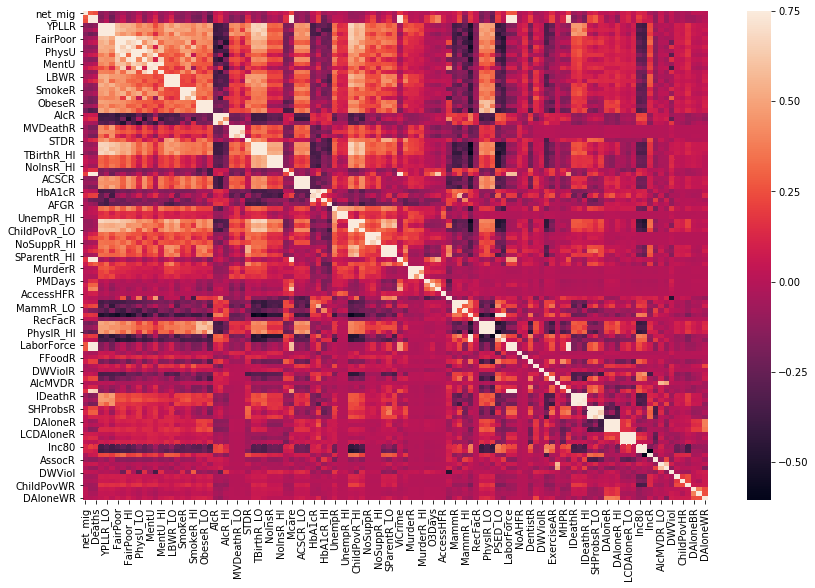

In [ ]:
cov_matrix = train.corr()
f, ax = plt.pyplot.subplots(figsize = (14,9))
sns.heatmap(cov_matrix, vmax = .75, square = False)

We'll now scale our data so that we can compare our results with the linear regression model's results.

In [ ]:
scaler = StandardScaler()
scaler.fit(train)
train_s = scaler.transform(train)
train_s = pd.DataFrame(train_s, index=train.index, columns=train.columns)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X = train_s.drop(['net_mig'], axis = 1)
y = train_s['net_mig']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 99)
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 99)

After many trials, we found our best hyperparameters to be 300 trees with a max depth of 20.

In [ ]:
param_dict = {"n_estimators": [300], "max_depth": [5]}
reg = RandomForestRegressor(n_jobs = -1)
gs = GridSearchCV(reg, param_dict, scoring = 'neg_mean_squared_error', cv = 4)
gs.fit(x_tr, y_tr)

In [ ]:
gs.cv_results_

We used the best_estimator to determine which hyperparameters were the best to use.

In [ ]:
gs.best_estimator_

In [ ]:
train_predictions = gs.predict(x_tr)
train_error = mean_squared_error(y_tr, train_predictions)
val_predictions = gs.predict(x_val)
val_error = mean_squared_error(y_val, val_predictions)

print(train_error)
print(val_error)

In [ ]:
test_predictions = gs.predict(X_test)
test_error = mean_squared_error(y_test, test_predictions)
print(test_error)